# Project: Tornadoes in America

## Introduction of Problem

In the United States tornadoes are a commonly occuring natural disaster, that can occur throughout the year.  Using data collected by the NCEI and NOAA (https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/) about tornadoes during 2024, analysis will be performed to see what areas are at most risk for tornadoes by looking at tornadoes that actually touched the ground and moved. Additionally, further analysis will be done to look into if time of year is a factor. The hypothesis is that there will be a difference in which locations are at risk of a tornado depending on the season of the year that it is.

## Import Libraries

In [4]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
import mapclassify
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.crs as ccrs # import projection
import cartopy.feature as cf # import features
import json
import folium
import mplleaflet

# Data Cleaning

## Read and filter data

Removing columns that will not be used when analyzing the data.

In [52]:
df = pd.read_csv('Tornadoes2024.csv') #read in data
df = df.loc[:, ['EVENT_ID','STATE','MONTH_NAME','BEGIN_LOCATION','END_LOCATION','BEGIN_LAT','END_LAT','BEGIN_LON','END_LON']] #keep necesarry variables for analysis
df=df.dropna() #remove null values
df.head() #print first 5 lines

EVENT_ID        STATE MONTH_NAME      BEGIN_LOCATION        END_LOCATION  \
0    1174463     OKLAHOMA      April      FREDERICK ARPT      FREDERICK ARPT   
5    1182348  MISSISSIPPI        May              ALGOMA              ALGOMA   
8    1181506  MISSISSIPPI        May  TISHOMINGO CO ARPT  TISHOMINGO CO ARPT   
9    1181499    TENNESSEE        May              EUREKA              EUREKA   
17   1221942       OREGON   November              MONROE              MONROE   

    BEGIN_LAT  END_LAT  BEGIN_LON   END_LON  
0     34.3444  34.3444   -98.9830  -98.9830  
5     34.1800  34.1800   -89.0300  -89.0300  
8     34.5100  34.5100   -88.2100  -88.2100  
9     35.2000  35.2000   -88.2400  -88.2400  
17    44.3240  44.3264  -123.3136 -123.3104

## Remove any entries where both beginning and ending lon and lat are the same

Entries where both the longitude and latitude do not change are considered "tornado possible weather" where they may have simply been rotation in the clouds or spiraling cold and hot fronts. This analysis is looking for tornadoes that actually touched the ground and could actually cause damage.

In [54]:
df_move = df[(df.BEGIN_LAT - df.END_LAT != 0) | (df.BEGIN_LON - df.END_LON != 0)] #keep values where either the lon or lat changes 
df_move.head() #print first 5 lines

EVENT_ID     STATE MONTH_NAME   BEGIN_LOCATION END_LOCATION  BEGIN_LAT  \
17    1221942    OREGON   November           MONROE       MONROE    44.3240   
18    1221959    OREGON   November            BANKS        BANKS    45.6200   
19    1216653      IOWA   November          BELKNAP      BELKNAP    40.8030   
48    1151472     TEXAS   February        CHILDRESS    CHILDRESS    34.3042   
101   1155977  ILLINOIS   February  HOFFMAN ESTATES    INVERNESS    42.0572   

     END_LAT  BEGIN_LON   END_LON  
17   44.3264  -123.3136 -123.3104  
18   45.6200  -123.4325 -123.4283  
19   40.8062   -92.3482  -92.3437  
48   34.4200  -100.2000 -100.2000  
101  42.0898   -88.1184  -88.0937

# Data Visualization

## Create initial visualization

Investigate what the data looks like without distinguishing between each season.

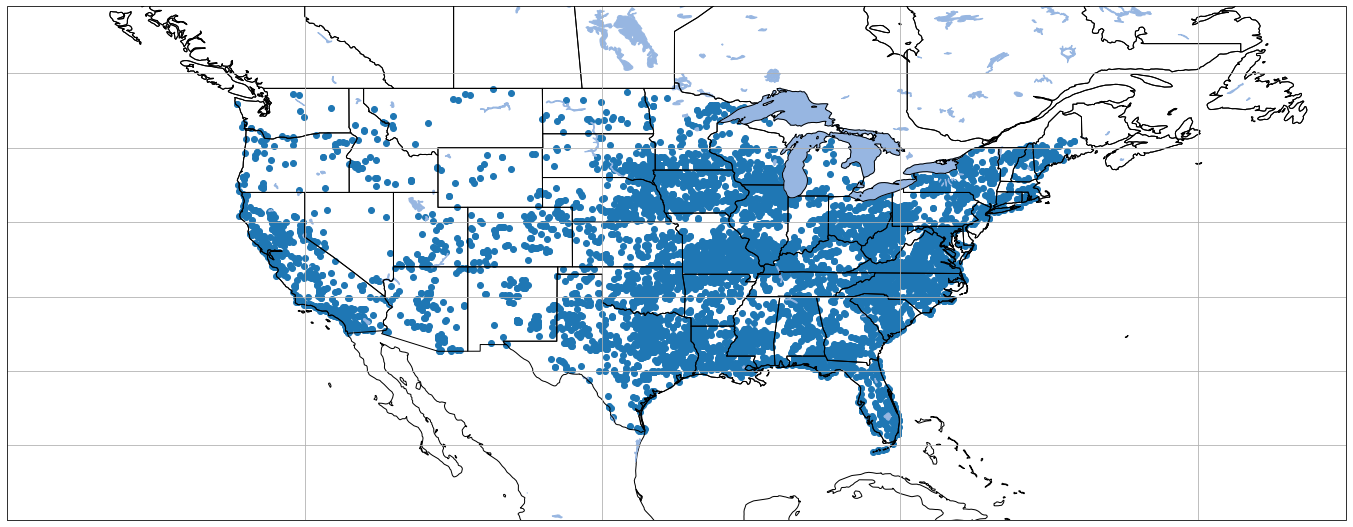

In [49]:
extant = [-140,-50,20, 45]
fig=plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extant) #set the extant of the map
ax.gridlines() #add gridlines
ax.coastlines(resolution='50m') #add coastlines
ax.add_feature(cf.LAKES) #add lakes
ax.add_feature(cf.STATES) #add states

plt.scatter(df_move['BEGIN_LON'],df_move['BEGIN_LAT'])

## Create dataframes for each season
Use a 3 month period to the determine each season as follows:
1. Winter = December, January, February
2. Spring = March, April, May
3. Summer = June, July, August
4. Fall = September, October, November

In [19]:
#create separate datasets for each season
df_winter = df_move[(df.MONTH_NAME == 'December') | (df.MONTH_NAME == 'January') | (df.MONTH_NAME == 'February')]
df_spring = df_move[(df.MONTH_NAME == 'March') | (df.MONTH_NAME == 'April') | (df.MONTH_NAME == 'May')]
df_summer = df_move[(df.MONTH_NAME == 'June') | (df.MONTH_NAME == 'July') | (df.MONTH_NAME == 'August')]
df_fall = df_move[(df.MONTH_NAME == 'September') | (df.MONTH_NAME == 'October') | (df.MONTH_NAME == 'November')]

/tmp/ipykernel_4230/1850995474.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_winter = df_move[(df.MONTH_NAME == 'December') | (df.MONTH_NAME == 'January') | (df.MONTH_NAME == 'February')]
/tmp/ipykernel_4230/1850995474.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_spring = df_move[(df.MONTH_NAME == 'March') | (df.MONTH_NAME == 'April') | (df.MONTH_NAME == 'May')]
/tmp/ipykernel_4230/1850995474.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_summer = df_move[(df.MONTH_NAME == 'June') | (df.MONTH_NAME == 'July') | (df.MONTH_NAME == 'August')]
/tmp/ipykernel_4230/1850995474.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fall = df_move[(df.MONTH_NAME == 'September') | (df.MONTH_NAME == 'October') | (df.MONTH_NAME == 'November')]


## Plot individual graphs

Plot a graph for each season to get an idea of how tornadoes for each individual season are spread across the continental United States.

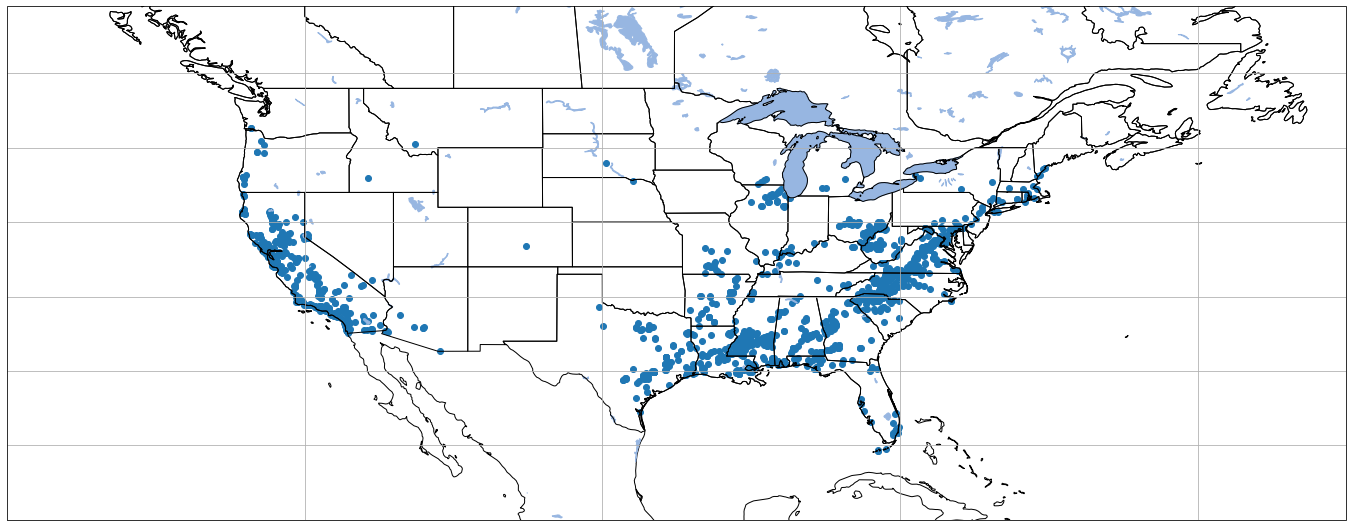

In [42]:
extant = [-140,-50,20, 45] #define outer border of map
fig=plt.figure(figsize=(24,18)) #define display size of figure
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extant) #set the extant of the map
ax.gridlines() #add gridlines
ax.coastlines(resolution='50m') #add coastlines to the map
ax.add_feature(cf.LAKES) #add lakes
ax.add_feature(cf.STATES) #add states

plt.scatter(df_winter['BEGIN_LON'],df_winter['BEGIN_LAT']) #plot the information of df_winter

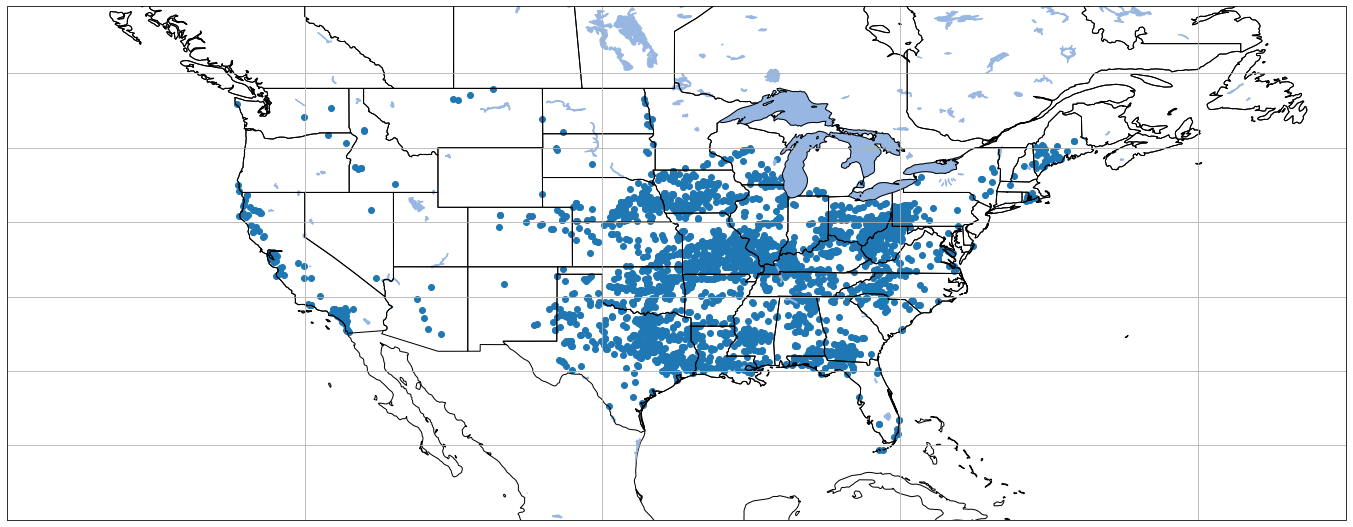

In [43]:
#process same as it was for winter
extant = [-140,-50,20, 45]
fig=plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extant)
ax.gridlines()
ax.coastlines(resolution='50m')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)

plt.scatter(df_spring['BEGIN_LON'],df_spring['BEGIN_LAT'])

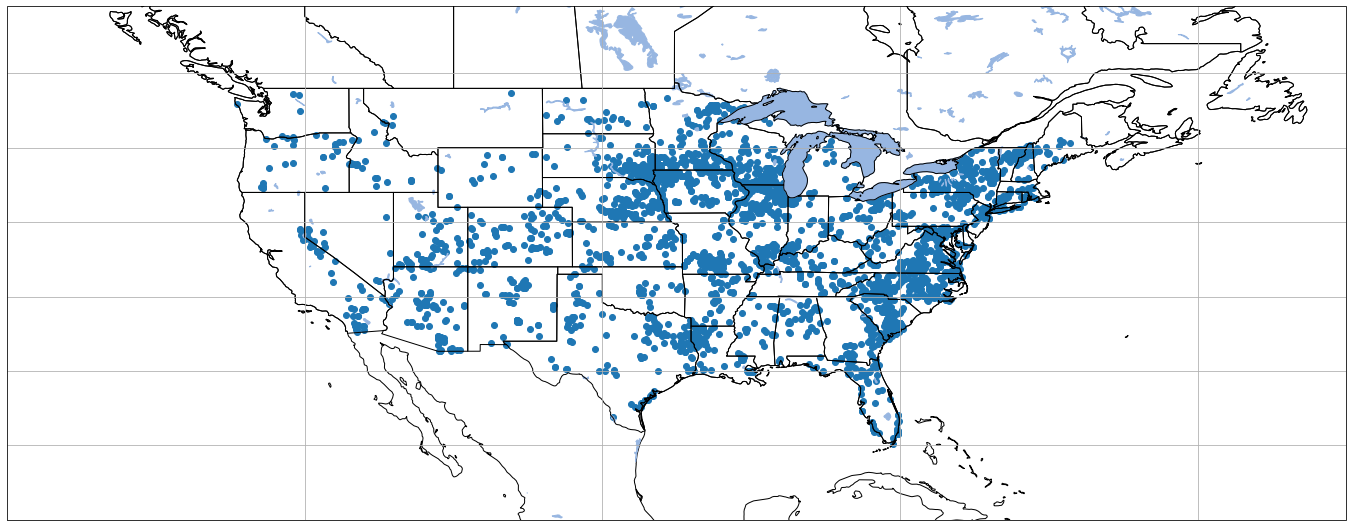

In [44]:
#process same as it was for winter
extant = [-140,-50,20, 45]
fig=plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extant)
ax.gridlines()
ax.coastlines(resolution='50m')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)

plt.scatter(df_summer['BEGIN_LON'],df_summer['BEGIN_LAT'])

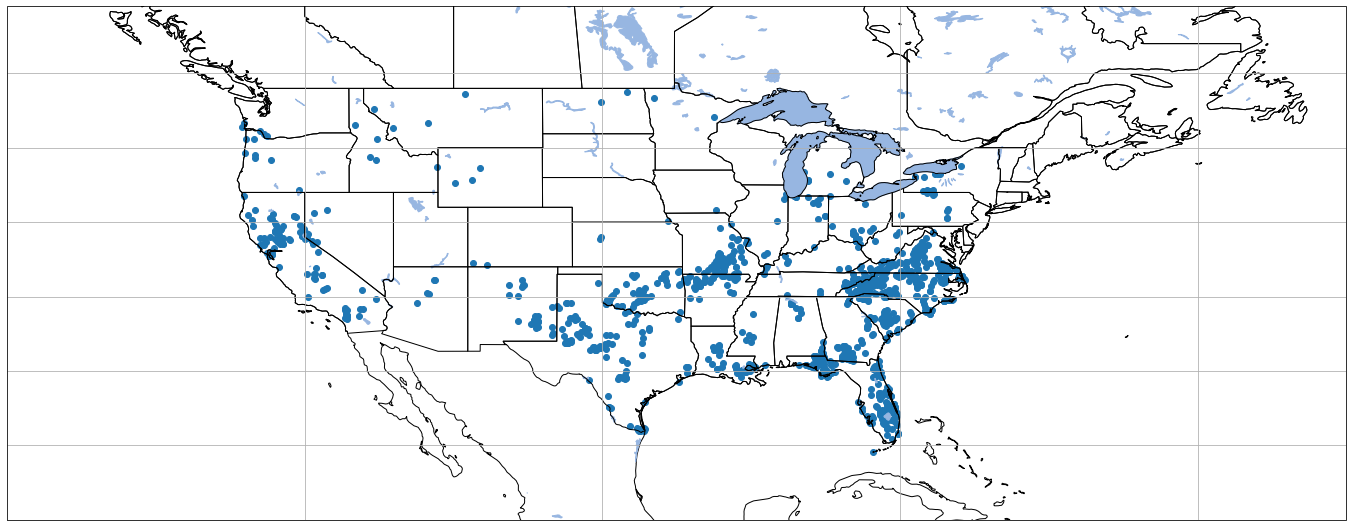

In [60]:
#process same as it was for winter
extant = [-140,-50,20, 45]
fig=plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extant)
ax.gridlines()
ax.coastlines(resolution='50m')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)

plt.scatter(df_fall['BEGIN_LON'],df_fall['BEGIN_LAT'])

## Combined plot

Plot all the graphs onto one singular map with winter being represented in blue, spring in red, summer in green, and fall in black. This helps get an idea if there is actually a distinct visible difference between seasons that cannot be seen on their individual maps.

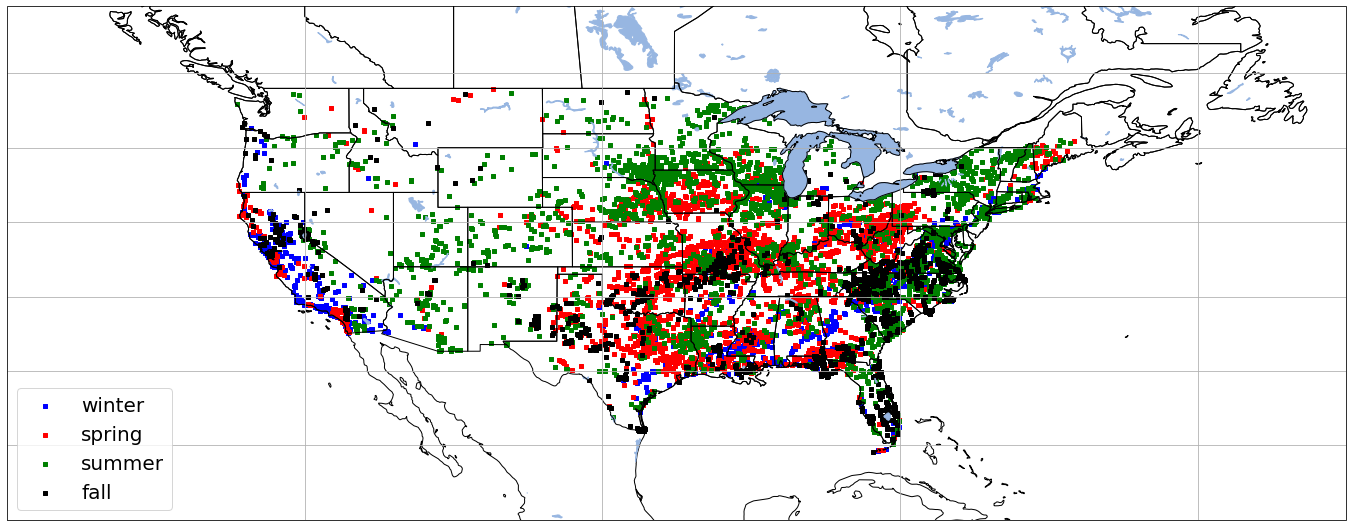

In [55]:
#process same as it was for winter
extant = [-140,-50,20, 45]
fig=plt.figure(figsize=(24,18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent(extant)
ax.gridlines()
ax.coastlines(resolution='50m')
ax.add_feature(cf.LAKES)
ax.add_feature(cf.STATES)

#add individual scatterplot onto the map, set x and y values, the color, shape of marker, and labels the plot
ax.scatter(x = df_winter['BEGIN_LON'],y = df_winter['BEGIN_LAT'], s=10, c='b', marker="s", label='winter')
ax.scatter(x = df_spring['BEGIN_LON'],y = df_spring['BEGIN_LAT'], s=10, c='r', marker="s", label='spring')
ax.scatter(x = df_summer['BEGIN_LON'],y = df_summer['BEGIN_LAT'], s=10, c='g', marker="s", label='summer')
ax.scatter(x = df_fall['BEGIN_LON'],y = df_fall['BEGIN_LAT'], s=10, c='k', marker="s", label='fall')
plt.legend(loc='lower left', fontsize = '20') #create a legend for the visualization

## Concluding discussion

There does seem to be a difference in what areas are at risk for tornadoes depending on the season that it currently is after looking at tornado data for all tornadoes that touched ground in 2024. In the winter, tornadoes generally touch down in relatively warmer climates and primarily along the coastlines of the continental United States. In the spring, the risk of tornadoes moves inwards. During this season, most of the central states, especially the Midwestern ones, in the United States are at an elevated risk of tornadoes. In the summer, the risk of tornadoes becomes more spread out. During the summer tornadoes are also seen in a fairly large quantity in the Great Plains region as well as in the Midwest and east coast. Finally, during the fall, the risk of tornadoes seems to move south and more toward warmer climates again. Here, only the southern Midwestern states, states with historically warmer climates, and southern coastal states are at an elevated risk of tornadoes. In the combined visualization, this information can really be seen as there seems to be fairly distinct clusters of similarly colored points across the United States. Potential further analysis may include looking at year-over-year data to see if this information is simply a one-off result of 2024 or a consistent trend, or looking into how specific geographic features, such as lakes or mountains, could also affect tornado occurances.